In [1]:
import os
os.environ["TORCH_DISABLE_TORCHDYNAMO"] = "1"
os.environ["TORCHINDUCTOR_DISABLE"] = "1"


In [2]:
import os
import time
import random
import math
import re
import unicodedata
import string
import collections
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [3]:
num_heads = 2
embed_dim = 512
seqLen = 256
encoder_layers = 2
decoder_layers = 2
dropout = 0.3
ff_dim = embed_dim * 4

PAD_ID = 0
BOS_ID = 1
EOS_ID = 2
UNK_ID = 3

PAD, BOS, EOS, UNK = PAD_ID, BOS_ID, EOS_ID, UNK_ID

vocab_size = 32000

batch_size = 64
learning_rate = 3e-4
adam_betas = (0.9, 0.98)
teacher_forcing_ratio = 1.0
epochs = 30

In [4]:
FILE_PATH = "/kaggle/input/empathetic-dialogues-facebook-ai/emotion-emotion_69k.csv"
COLUMNS_TO_USE = ["Situation", "emotion", "empathetic_dialogues", "labels"]

def load_data(file_path: str = FILE_PATH) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path, usecols=COLUMNS_TO_USE)
        print(f"Successfully loaded {len(df)} rows from Kaggle dataset.")
        return df
    except FileNotFoundError:
        print(f"Error: file not found at '{file_path}'.")
        return pd.DataFrame()

df_raw = load_data()

if not df_raw.empty:
    print("\nFirst 5 rows of loaded data:")
    print(df_raw.head())
    print (len(df_raw))

Successfully loaded 64636 rows from Kaggle dataset.

First 5 rows of loaded data:
                                           Situation      emotion  \
0  I remember going to the fireworks with my best...  sentimental   
1  I remember going to the fireworks with my best...  sentimental   
2  I remember going to the fireworks with my best...  sentimental   
3  I remember going to the fireworks with my best...  sentimental   
4  I remember going to the fireworks with my best...  sentimental   

                                empathetic_dialogues  \
0  Customer :I remember going to see the firework...   
1  Customer :This was a best friend. I miss her.\...   
2              Customer :We no longer talk.\nAgent :   
3  Customer :Was this a friend you were in love w...   
4             Customer :Where has she gone?\nAgent :   

                                              labels  
0  Was this a friend you were in love with, or ju...  
1                                Where has she gone?  
2

In [6]:
import re
import unicodedata

def normalize(s: str) -> str:
    s = "" if s is None else str(s)
    s = unicodedata.normalize("NFC", s).lower()
    s = (s.replace("“","\"").replace("”","\"").replace("‘","'").replace("’","'")
         .replace("—","-").replace("–","-").replace("…","..."))
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [8]:
import re

_CUST_SEG = r"customer\s*:?\s*"
_AGENT_SEG = r"agent\s*:?\s*"

def extract_customer(cell: str) -> str:
    if not isinstance(cell, str):
        return ""
    s = normalize(cell)
    last_agent = None
    for m in re.finditer(_AGENT_SEG, s, flags=re.I):
        last_agent = m
    agent_cut = last_agent.start() if last_agent else len(s)
    matches = list(re.finditer(
        rf"{_CUST_SEG}(.*?)(?=\s*(?:{_AGENT_SEG}|{_CUST_SEG}|$))",
        s, flags=re.I | re.S
    ))
    if not matches:
        return ""
    candidates = [m for m in matches if m.end() <= agent_cut]
    last = candidates[-1] if candidates else matches[-1]
    return normalize(last.group(1))


In [9]:
def build_XY(df: pd.DataFrame) -> pd.DataFrame:
    emo = df["emotion"].map(normalize)
    sit = df["Situation"].map(normalize)
    y = df["labels"].map(normalize)
    cust = df["empathetic_dialogues"].map(extract_customer)
    x = "<emo_" + emo + "> <sep> " + sit + " <sep> " + cust + " Agent:"
    pairs = pd.DataFrame({"X": x, "Y": y})
    pairs = pairs[(pairs.X.str.len() > 0) & (pairs.Y.str.len() > 0)].reset_index(drop=True)
    return pairs

pairs = build_XY(df_raw)
print(pairs.head())


                                                   X  \
0  <emo_sentimental> <sep> i remember going to th...   
1  <emo_sentimental> <sep> i remember going to th...   
2  <emo_sentimental> <sep> i remember going to th...   
3  <emo_sentimental> <sep> i remember going to th...   
4  <emo_sentimental> <sep> i remember going to th...   

                                                   Y  
0  was this a friend you were in love with, or ju...  
1                                where has she gone?  
2  oh was this something that happened because of...  
3                this was a best friend. i miss her.  
4                                 we no longer talk.  


In [2]:
from sklearn.model_selection import train_test_split

if not pairs.empty:
    train_df, rest = train_test_split(pairs, test_size=0.2, random_state=42, shuffle=True)
    val_df, test_df = train_test_split(rest, test_size=0.5, random_state=42, shuffle=True)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    train_df.to_csv("train.csv", index=False)
    val_df.to_csv("val.csv", index=False)
    test_df.to_csv("test.csv", index=False)
else:
    pass



Step 3: Training Tokenizer and Encoding Data...
Found 34 emotion tokens (raw).
Using 33 valid emotion tokens: ['<emo_afraid>', '<emo_angry>', '<emo_annoyed>', '<emo_anticipating>', '<emo_anxious>', '<emo_apprehensive>', '<emo_ashamed>', '<emo_caring>', '<emo_confident>', '<emo_content>', '<emo_devastated>', '<emo_disappointed>', '<emo_disgusted>', '<emo_embarrassed>', '<emo_excited>', '<emo_faithful>', '<emo_furious>', '<emo_grateful>', '<emo_guilty>', '<emo_hopeful>'] ...
Ignored 1 invalid tokens: ['<emo_(>'] 
Tokenizer trained. Vocabulary size: 32000.
Discovered 34 emotion classes.
All splits encoded. Train=51708 Val=6464 Test=6464 Total=64636
Sample X tokens: [31926, 29, 31926, 37, 39, 172, 52, 142, 805, 6485, 104, 66, 1527, 54, 313, 210, 31945, 671, 112, 591, 54, 538, 152, 66, 1582, 286, 846, 909, 52, 501, 148, 261]
Sample Y tokens: [1, 215, 170, 204, 523, 12738, 112, 85, 66, 456, 170, 123, 13930, 204, 199, 31945, 2]
Sample emo_id: 26


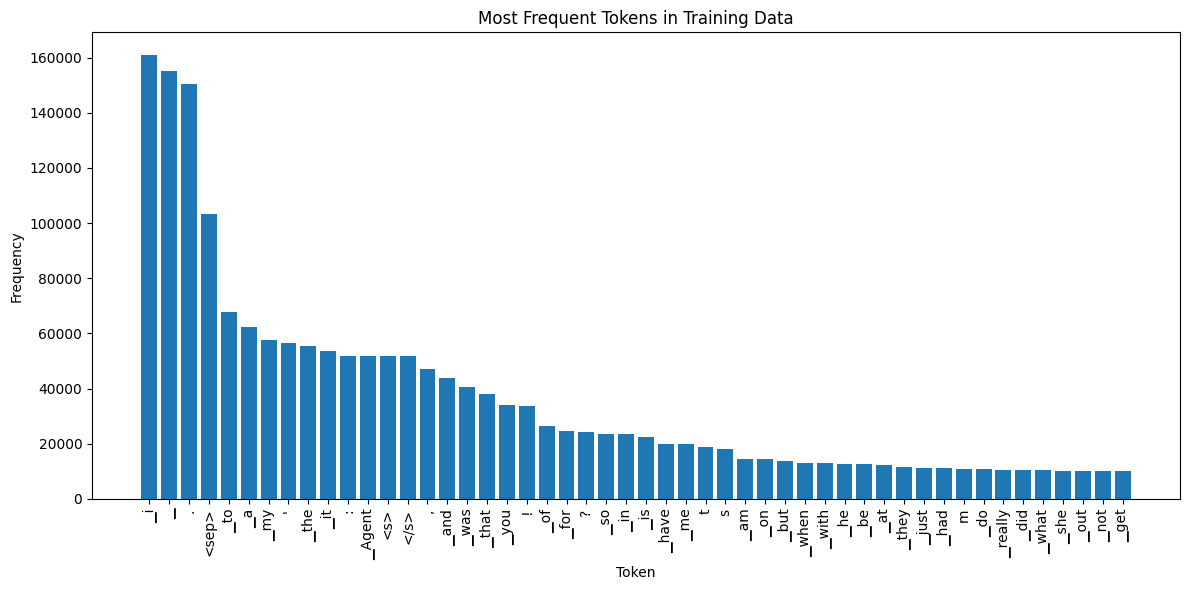

In [5]:
import sentencepiece as spm
import torch
import re
import pandas as pd

if 'train_df' in locals() and not train_df.empty:
    print("\nStep 3: Training Tokenizer and Encoding Data...")
    train_text = pd.concat([train_df["X"], train_df["Y"]], axis=0).tolist()
    with open("spm_train_text.txt","w",encoding="utf-8") as f:
        for s in train_text:
            f.write(s + "\n")

    raw_emo_tokens = sorted(set(re.findall(r"<emo_[^>\s]+>", " ".join(train_df["X"].tolist()))))
    valid_pat = re.compile(r"^<emo_[a-z0-9_]+>$")
    emo_tokens_valid = [t for t in raw_emo_tokens if valid_pat.match(t)]
    emo_tokens_invalid = sorted(set(raw_emo_tokens) - set(emo_tokens_valid))

    print(f"Found {len(raw_emo_tokens)} emotion tokens (raw).")
    print(f"Using {len(emo_tokens_valid)} valid emotion tokens:", emo_tokens_valid[:20], "..." if len(emo_tokens_valid) > 20 else "")
    if len(emo_tokens_invalid):
        print(f"Ignored {len(emo_tokens_invalid)} invalid tokens:", emo_tokens_invalid[:10], "..." if len(emo_tokens_invalid) > 10 else "")

    spm.SentencePieceTrainer.Train(
        input="spm_train_text.txt",
        model_prefix="spm_bpe",
        vocab_size=vocab_size,
        model_type="bpe",
        character_coverage=1.0,
        pad_id=PAD,
        bos_id=BOS,
        eos_id=EOS,
        unk_id=UNK,
        user_defined_symbols=emo_tokens_valid + ["<sep>"]
    )
    sp = spm.SentencePieceProcessor()
    sp.load("spm_bpe.model")
    print(f"Tokenizer trained. Vocabulary size: {sp.get_piece_size()}.")

    emo_tags = sorted(set(re.findall(r"<emo_([a-z0-9_]+)>", " ".join(train_df["X"].tolist()))))
    emotions = ["unknown"] + emo_tags
    emo2id = {e:i for i,e in enumerate(emotions)}
    id2emo = {i:e for e,i in emo2id.items()}
    print(f"Discovered {len(emotions)} emotion classes.")

    def encode_split(df: pd.DataFrame) -> list:
        out = []
        xs = df["X"].tolist()
        ys = df["Y"].tolist()
        for x, y in zip(xs, ys):
            m = re.search(r"<emo_([a-z0-9_]+)>", x)
            emo = m.group(1) if m else "unknown"
            ei = emo2id.get(emo, 0)
            src_ids = sp.encode(x, out_type=int)
            tgt_ids = [BOS] + sp.encode(y, out_type=int) + [EOS]
            out.append({"src_ids": src_ids, "tgt_ids": tgt_ids, "emo_id": ei})
        return out

    train_list = encode_split(train_df)
    val_list = encode_split(val_df)
    test_list = encode_split(test_df)
    total = len(train_list) + len(val_list) + len(test_list)
    print(f"All splits encoded. Train={len(train_list)} Val={len(val_list)} Test={len(test_list)} Total={total}")
    print("Sample X tokens:", train_list[0]["src_ids"][:32] if len(train_list) else [])
    print("Sample Y tokens:", train_list[0]["tgt_ids"][:32] if len(train_list) else [])
    print("Sample emo_id:", train_list[0]["emo_id"] if len(train_list) else None)
    from collections import Counter
    import matplotlib.pyplot as plt
    
    # Combine all source and target token IDs from the training set
    all_ids = [tid for sample in train_list for tid in sample["src_ids"] + sample["tgt_ids"]]
    
    # Count token frequency
    token_counts = Counter(all_ids)
    
    # Get the most common tokens (e.g., top 30)
    most_common = token_counts.most_common(50)
    
    # Convert token IDs to token strings for readability
    tokens = [sp.id_to_piece(i) for i, _ in most_common]
    counts = [c for _, c in most_common]
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.bar(tokens, counts)
    plt.xticks(rotation=90)
    plt.xlabel("Token")
    plt.ylabel("Frequency")
    plt.title("Most Frequent Tokens in Training Data")
    plt.tight_layout()
    plt.show()

else:
    print("Skipping Step 3: Training DataFrame is empty.")


In [7]:
# Count frequency of the phrase "I'm sorry to hear that" in your training, validation, and test sets
def phrase_frequency(df, phrase="i'm sorry to hear that"):
    # Normalize case to handle variations like "I'm", "im", etc.
    texts = df["Y"].str.lower().tolist()
    count = sum(phrase in t for t in texts)
    total = len(texts)
    freq = count / total if total > 0 else 0
    print(f"Phrase '{phrase}' found {count} times in {total} samples ({freq:.2%}).")

print("\nChecking phrase frequency in dataset:")
phrase_frequency(train_df)
phrase_frequency(val_df)
phrase_frequency(test_df)


def phrase_search(df, patterns):
    text = " ".join(df["Y"].str.lower().tolist())
    counts = {p: len(re.findall(p, text)) for p in patterns}
    for p, c in counts.items():
        print(f"'{p}' → {c} matches")

patterns = [r"i[' ]?m sorry", r"sorry to hear", r"apolog", r"that sounds tough"]
phrase_search(train_df, patterns)


mask = train_df["Y"].str.lower().str.contains("i'm sorry to hear that")
emo_in_sorry = train_df.loc[mask, "X"].str.extract(r"(<emo_[a-z0-9_]+>)")[0].value_counts()
print("\nEmotion tags most associated with 'I'm sorry to hear that':")
print(emo_in_sorry.head(10))



Checking phrase frequency in dataset:
Phrase 'i'm sorry to hear that' found 202 times in 51708 samples (0.39%).
Phrase 'i'm sorry to hear that' found 31 times in 6464 samples (0.48%).
Phrase 'i'm sorry to hear that' found 25 times in 6464 samples (0.39%).
'i[' ]?m sorry' → 568 matches
'sorry to hear' → 683 matches
'apolog' → 70 matches
'that sounds tough' → 1 matches

Emotion tags most associated with 'I'm sorry to hear that':
0
<emo_sad>             38
<emo_lonely>          27
<emo_devastated>      17
<emo_disappointed>    15
<emo_ashamed>         10
<emo_anxious>         10
<emo_furious>          9
<emo_angry>            6
<emo_annoyed>          6
<emo_afraid>           6
Name: count, dtype: int64


In [ ]:
def detok(ids, sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID):
    if isinstance(ids, torch.Tensor):
        ids = ids.tolist()
    keep = []
    for t in ids:
        if t == pad_id or t == bos_id:
            continue
        if t == eos_id:
            break
        keep.append(t)
    return sp.decode(keep)

if 'train_list' in locals() and len(train_list) > 0:
    n = min(2, len(train_list))
    for i in range(n):
        ex = train_list[i]
        print("\n--- sample", i, "---")
        print("X:", detok(ex["src_ids"], sp))
        print("Y:", detok(ex["tgt_ids"], sp))
        if "emo_id" in ex:
            emo_name = id2emo.get(ex["emo_id"], "unknown") if 'id2emo' in locals() else ex["emo_id"]
            print("emo_id:", ex["emo_id"], "| emo:", emo_name)


In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch

def check_length_and_tensorize(batch_of_examples, max_len_source, max_len_target):
    source_tensors, target_tensors, emo_ids = [], [], []
    for example in batch_of_examples:
        source_ids = example["src_ids"][:max_len_source]
        target_ids = example["tgt_ids"][:max_len_target]
        if len(target_ids) < 2:
            target_ids = target_ids + [EOS_ID]
        source_tensors.append(torch.tensor(source_ids, dtype=torch.long))
        target_tensors.append(torch.tensor(target_ids, dtype=torch.long))
        emo_ids.append(example.get("emo_id", 0))
    return source_tensors, target_tensors, emo_ids

def pad_sequences_and_create_masks(source_tensors, target_tensors, pad_token_id):
    source_padded = pad_sequence(source_tensors, batch_first=True, padding_value=pad_token_id)
    target_padded = pad_sequence(target_tensors, batch_first=True, padding_value=pad_token_id)
    target_input, target_output = target_padded[:, :-1], target_padded[:, 1:]
    source_padding_mask = (source_padded == pad_token_id)
    target_padding_mask = (target_input == pad_token_id)
    return source_padded, source_padding_mask, target_input, target_output, target_padding_mask

def create_batch_collator(max_len_source, max_len_target, pad_token_id):
    def collate_function(batch_of_examples):
        source_tensors, target_tensors, emo_ids = check_length_and_tensorize(
            batch_of_examples, max_len_source, max_len_target
        )
        src, src_pad, tgt_in, tgt_out, tgt_pad = pad_sequences_and_create_masks(
            source_tensors, target_tensors, pad_token_id
        )
        return {
            "src": src,
            "src_pad": src_pad,
            "tgt_in": tgt_in,
            "tgt_out": tgt_out,
            "tgt_pad": tgt_pad,
            "emo_ids": torch.tensor(emo_ids, dtype=torch.long)
        }
    return collate_function


In [ ]:
from torch.utils.data import DataLoader

collate_fn = create_batch_collator(
    max_len_source=seqLen,
    max_len_target=seqLen,
    pad_token_id=PAD_ID
)

print("Creating PyTorch DataLoaders...")

train_loader = DataLoader(
    train_list,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_list,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_list,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

print("DataLoaders initialized.")
print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")

if len(train_loader) > 0:
    batch = next(iter(train_loader))
    print(batch["src"].shape)
    print(batch["tgt_in"].shape)
    print(batch["tgt_out"].shape)
    print(batch["src_pad"].shape)
    print(batch["tgt_pad"].shape)
    print(batch["emo_ids"].shape)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def make_causal_mask(size):
    mask = torch.triu(torch.ones(size, size, dtype=torch.bool), diagonal=1)
    return mask.unsqueeze(0).unsqueeze(0)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)
        x = x + self.pe[:seq_len].transpose(0, 1)
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, query, key, value, mask=None):
        N, Lq, d_model = query.shape
        Lk = key.shape[1]
        Q = self.q_proj(query).view(N, Lq, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_proj(key).view(N, Lk, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_proj(value).view(N, Lk, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        attention_weights = self.dropout(F.softmax(scores, dim=-1))
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(N, Lq, d_model)
        return self.out_proj(context)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w_2(self.dropout(F.gelu(self.w_1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.attn_norm = nn.LayerNorm(d_model)
        self.ffn_norm = nn.LayerNorm(d_model)
        self.attn_dropout = nn.Dropout(dropout)
        self.ffn_dropout = nn.Dropout(dropout)
    def forward(self, src: torch.Tensor, src_pad_mask: torch.BoolTensor) -> torch.Tensor:
        attn_mask = src_pad_mask.unsqueeze(1).unsqueeze(2)
        norm_src = self.attn_norm(src)
        attn_out = self.self_attn(norm_src, norm_src, norm_src, mask=attn_mask)
        src = src + self.attn_dropout(attn_out)
        norm_src = self.ffn_norm(src)
        ffn_out = self.ffn(norm_src)
        src = src + self.ffn_dropout(ffn_out)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.attn1_norm = nn.LayerNorm(d_model)
        self.attn2_norm = nn.LayerNorm(d_model)
        self.ffn_norm = nn.LayerNorm(d_model)
        self.attn1_dropout = nn.Dropout(dropout)
        self.attn2_dropout = nn.Dropout(dropout)
        self.ffn_dropout = nn.Dropout(dropout)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
    def forward(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_pad_mask: torch.BoolTensor, memory_pad_mask: torch.BoolTensor) -> torch.Tensor:
        L_tgt = tgt.size(1)
        causal_mask = make_causal_mask(L_tgt).to(tgt.device)
        tgt_attn_pad_mask = tgt_pad_mask.unsqueeze(1).unsqueeze(2)
        full_tgt_mask = tgt_attn_pad_mask | causal_mask
        norm_tgt = self.attn1_norm(tgt)
        attn_out1 = self.self_attn(norm_tgt, norm_tgt, norm_tgt, mask=full_tgt_mask)
        tgt = tgt + self.attn1_dropout(attn_out1)
        mem_attn_mask = memory_pad_mask.unsqueeze(1).unsqueeze(2)
        norm_tgt = self.attn2_norm(tgt)
        attn_out2 = self.cross_attn(query=norm_tgt, key=memory, value=memory, mask=mem_attn_mask)
        tgt = tgt + self.attn2_dropout(attn_out2)
        norm_tgt = self.ffn_norm(tgt)
        ffn_out = self.ffn(norm_tgt)
        tgt = tgt + self.ffn_dropout(ffn_out)
        return tgt

class Encoder(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_heads: int, d_ff: int, num_layers: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
    def forward(self, src: torch.Tensor, src_pad_mask: torch.BoolTensor) -> torch.Tensor:
        src = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        src = self.pos_encoder(src)
        for layer in self.layers:
            src = layer(src, src_pad_mask)
        return self.norm(src)

class Decoder(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_heads: int, d_ff: int, num_layers: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_ID)
        self.pos_decoder = PositionalEncoding(d_model, max_len, dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
    def forward(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_pad_mask: torch.BoolTensor, memory_pad_mask: torch.BoolTensor) -> torch.Tensor:
        tgt = self.embedding(tgt) * math.sqrt(self.embedding.embedding_dim)
        tgt = self.pos_decoder(tgt)
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_pad_mask, memory_pad_mask)
        return self.norm(tgt)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=embed_dim, num_heads=num_heads, d_ff=ff_dim, num_encoder_layers=encoder_layers, num_decoder_layers=decoder_layers, dropout=dropout, max_len=256, num_emotions=None):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_heads, d_ff, num_encoder_layers, dropout, max_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_heads, d_ff, num_decoder_layers, dropout, max_len)
        self.generator = nn.Linear(d_model, tgt_vocab_size)
        self.emo_head = nn.Linear(d_model, num_emotions) if num_emotions is not None else None
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        self.generator.weight = self.decoder.embedding.weight
    def forward(self, src: torch.Tensor, tgt_in: torch.Tensor, src_pad: torch.BoolTensor, tgt_pad: torch.BoolTensor):
        memory = self.encoder(src, src_pad)
        output = self.decoder(tgt_in, memory, tgt_pad, src_pad)
        logits = self.generator(output)
        emo_logits = None
        if self.emo_head is not None:
            mask = (~src_pad).float().unsqueeze(-1)
            pooled = (memory * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1.0)
            emo_logits = self.emo_head(pooled)
        return logits, emo_logits


In [ ]:
import torch
import torch.nn as nn

class AdamWLite:
    def __init__(self, params, lr=3e-4, betas=(0.9, 0.98), eps=1e-8, weight_decay=1e-4):
        self.params = [p for p in params if p.requires_grad]
        self.lr, (self.b1, self.b2), self.eps, self.wd = lr, betas, eps, weight_decay
        self.state = {
            id(p): {
                "step": 0,
                "m": torch.zeros_like(p, memory_format=torch.preserve_format),
                "v": torch.zeros_like(p, memory_format=torch.preserve_format),
            }
            for p in self.params
        }

    @torch.no_grad()
    def zero_grad(self, set_to_none: bool = False):
        for p in self.params:
            if p.grad is not None:
                if set_to_none:
                    p.grad = None
                else:
                    p.grad.zero_()

    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            st = self.state[id(p)]
            st["step"] += 1
            g = p.grad
            m, v = st["m"], st["v"]
            m.mul_(self.b1).add_(g, alpha=1 - self.b1)
            v.mul_(self.b2).addcmul_(g, g, value=1 - self.b2)
            t = st["step"]
            mhat = m / (1 - self.b1 ** t)
            vhat = v / (1 - self.b2 ** t)
            if self.wd != 0.0:
                p.add_(p, alpha=-self.lr * self.wd)
            p.addcdiv_(mhat, vhat.sqrt().add_(self.eps), value=-self.lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_emotions = len(id2emo) if 'id2emo' in locals() else None

model = Transformer(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=embed_dim,
    num_heads=num_heads,
    d_ff=ff_dim,
    num_encoder_layers=encoder_layers,
    num_decoder_layers=decoder_layers,
    dropout=dropout,
    num_emotions=num_emotions
).to(device)

print("Transformer Model Initialized.")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Emotion head classes: {num_emotions if num_emotions is not None else 0}")

criterion_train = nn.CrossEntropyLoss(ignore_index=PAD_ID, label_smoothing=0.1)
criterion_eval = nn.CrossEntropyLoss(ignore_index=PAD_ID)
emo_criterion = nn.CrossEntropyLoss()
print("Loss Function: CrossEntropyLoss + label_smoothing=0.1 (ignoring PAD tokens)")

optimizer = AdamWLite(
    model.parameters(),
    lr=learning_rate,
    betas=adam_betas,
    weight_decay=1e-4
)
print(f"Optimizer: AdamWLite (lr={learning_rate}, betas={adam_betas}, weight_decay=1e-4)")


In [ ]:
model.train()
batch = next(iter(train_loader))

src = batch['src'].to(device)
src_pad = batch['src_pad'].to(device)
tgt_in = batch['tgt_in'].to(device)
tgt_out = batch['tgt_out'].to(device)
tgt_pad = batch['tgt_pad'].to(device)
emo_ids = batch.get('emo_ids', None)
if emo_ids is not None:
    emo_ids = emo_ids.to(device)

optimizer.zero_grad()
out = model(src, tgt_in, src_pad, tgt_pad)
if isinstance(out, tuple):
    logits, emo_logits = out
else:
    logits, emo_logits = out, None

loss_tok = criterion_train(logits.view(-1, logits.size(-1)), tgt_out.contiguous().view(-1))
if emo_logits is not None and emo_ids is not None:
    loss_emo = emo_criterion(emo_logits, emo_ids)
    loss = loss_tok + 0.1 * loss_emo
else:
    loss = loss_tok

loss.backward()
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
optimizer.step()

print("Smoke test OK. Loss:", float(loss))


In [ ]:
clip_value = 1.0
def train_epoch(model, dataloader, optimizer, criterion_tok, criterion_emo=None, clip_value=clip_value, device=device):
    model.train()
    epoch_loss = 0.0
    for batch in dataloader:
        src = batch['src'].to(device)
        src_pad = batch['src_pad'].to(device)
        tgt_in = batch['tgt_in'].to(device)
        tgt_out = batch['tgt_out'].to(device)
        tgt_pad = batch['tgt_pad'].to(device)
        emo_ids = batch.get('emo_ids', None)
        if emo_ids is not None:
            emo_ids = emo_ids.to(device)
        optimizer.zero_grad()
        out = model(src, tgt_in, src_pad, tgt_pad)
        if isinstance(out, tuple):
            logits, emo_logits = out
        else:
            logits, emo_logits = out, None
        loss_tok = criterion_tok(logits.view(-1, logits.size(-1)), tgt_out.contiguous().view(-1))
        if emo_logits is not None and emo_ids is not None and criterion_emo is not None:
            loss_emo = criterion_emo(emo_logits, emo_ids)
            loss = loss_tok + 0.1 * loss_emo
        else:
            loss = loss_tok
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / max(1, len(dataloader))


In [ ]:
def evaluate_perplexity(model, dataloader, criterion_tok, criterion_emo=None, device=device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            src_pad = batch['src_pad'].to(device)
            tgt_in = batch['tgt_in'].to(device)
            tgt_out = batch['tgt_out'].to(device)
            tgt_pad = batch['tgt_pad'].to(device)
            emo_ids = batch.get('emo_ids', None)
            if emo_ids is not None:
                emo_ids = emo_ids.to(device)
            out = model(src, tgt_in, src_pad, tgt_pad)
            if isinstance(out, tuple):
                logits, emo_logits = out
            else:
                logits, emo_logits = out, None
            loss_tok = criterion_tok(logits.view(-1, logits.size(-1)), tgt_out.contiguous().view(-1))
            if emo_logits is not None and emo_ids is not None and criterion_emo is not None:
                loss_emo = criterion_emo(emo_logits, emo_ids)
                loss = loss_tok + 0.1 * loss_emo
            else:
                loss = loss_tok
            total_loss += loss.item()
    avg_loss = total_loss / max(1, len(dataloader))
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity


In [ ]:
!pip install sacrebleu rouge-score

In [ ]:
import time
import math
import os
from tqdm.auto import tqdm

MODEL_SAVE_PATH = 'best_transformer_model.pt'

def _get_lr(optimizer):
    if hasattr(optimizer, "param_groups"):
        return optimizer.param_groups[0]["lr"]
    return getattr(optimizer, "lr", None)

def _set_lr(optimizer, new_lr):
    if hasattr(optimizer, "param_groups"):
        for pg in optimizer.param_groups:
            pg["lr"] = new_lr
    else:
        optimizer.lr = new_lr

def _greedy_decode_texts(model, sp, batch, max_new_tokens=64):
    src = batch['src'].to(device)
    src_pad = batch['src_pad'].to(device)
    B = src.size(0)
    tgt = torch.full((B,1), BOS_ID, dtype=torch.long, device=src.device)
    finished = torch.zeros(B, dtype=torch.bool, device=src.device)
    for _ in range(max_new_tokens):
        tgt_pad = (tgt == PAD_ID)
        out = model(src, tgt, src_pad, tgt_pad)
        logits = out[0] if isinstance(out, tuple) else out
        next_token = logits[:,-1,:].argmax(dim=-1, keepdim=True)
        tgt = torch.cat([tgt, next_token], dim=1)
        finished |= (next_token.squeeze(1) == EOS_ID)
        if bool(finished.all()):
            break
    preds = []
    refs = []
    for i in range(B):
        preds.append(detok(tgt[i].tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID))
        refs.append(detok(batch['tgt_out'][i].tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID))
    return preds, refs

def _eval_text_metrics(model, val_loader, sp, max_batches=10):
    try:
        from sacrebleu import corpus_bleu
        from sacrebleu.metrics import CHRF
        from rouge_score import rouge_scorer
    except Exception:
        print("Metrics packages missing; install sacrebleu and rouge-score to compute BLEU/chrF/ROUGE-L.")
        return {"bleu": 0.0, "chrf": 0.0, "rougeL": 0.0}
    H = []
    R = []
    with torch.no_grad():
        it = iter(val_loader)
        for _ in range(min(max_batches, len(val_loader))):
            try:
                batch = next(it)
            except StopIteration:
                break
            preds, refs = _greedy_decode_texts(model, sp, batch, max_new_tokens=64)
            H.extend(preds)
            R.extend(refs)
    if len(H) == 0:
        return {"bleu": 0.0, "chrf": 0.0, "rougeL": 0.0}
    bleu = corpus_bleu(H, [R]).score
    chrf = CHRF(word_order=2).corpus_score(H, [R]).score
    rs = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rougeL = sum(rs.score(r, h)['rougeL'].fmeasure for h, r in zip(H, R)) / len(H)
    return {"bleu": float(bleu), "chrf": float(chrf), "rougeL": float(rougeL)}

def run_training_loop(
    model, train_loader, val_loader, optimizer, criterion, epochs, device=device,
    patience=3, lr_decay=0.5, min_lr=1e-5, sp=None, show_samples=3
):
    print(f"\nStarting training for {epochs} epochs...")
    best_bleu = -1.0
    best_epoch = -1
    bad_epochs = 0
    train_losses = []
    val_perplexities = []
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        train_loss = train_epoch(model, train_loader, optimizer, criterion, clip_value=1.0, device=device)
        val_loss, val_ppl = evaluate_perplexity(model, val_loader, criterion_eval, device=device)
        metrics = _eval_text_metrics(model, val_loader, sp, max_batches=10)
        t1 = time.time()
        cur_lr = _get_lr(optimizer)
        print(f"\nEpoch {epoch:02}/{epochs} | {int((t1-t0)//60)}m {int((t1-t0)%60)}s | LR {cur_lr:.6f}")
        print(f"Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val PPL {val_ppl:.2f}")
        print(f"Val BLEU {metrics['bleu']:.2f} | ROUGE-L {metrics['rougeL']:.4f} | chrF {metrics['chrf']:.2f}")
        train_losses.append(train_loss)
        val_perplexities.append(val_ppl)
        improved = metrics['bleu'] > best_bleu + 1e-6
        if improved:
            best_bleu = metrics['bleu']
            best_epoch = epoch
            bad_epochs = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Saved new best by BLEU: {best_bleu:.2f}")
        else:
            bad_epochs += 1
            new_lr = max(min_lr, cur_lr * lr_decay)
            if new_lr < cur_lr:
                _set_lr(optimizer, new_lr)
                print(f"LR reduced: {cur_lr:.6f} → {new_lr:.6f}")
            if bad_epochs >= patience:
                print(f"Early stopping (no BLEU improvement for {patience} epochs).")
                break
        if sp is not None and show_samples > 0:
            with torch.no_grad():
                batch = next(iter(val_loader))
                preds, refs = _greedy_decode_texts(model, sp, batch, max_new_tokens=64)
                for i in range(min(show_samples, len(preds))):
                    print("X:", detok(batch['src'][i].tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID))
                    print("Y_true:", refs[i])
                    print("Y_pred:", preds[i])
                    print("—")
    print(f"\nBest epoch {best_epoch} | Best BLEU {best_bleu:.2f} | Checkpoint: {MODEL_SAVE_PATH}")
    return train_losses, val_perplexities


In [ ]:
history = run_training_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion_train,     
    epochs=epochs,
    device=device,
    sp=sp
)


In [ ]:
# 1) Recreate model architecture
best_model = Transformer(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=embed_dim,
    num_heads=num_heads,
    d_ff=ff_dim,
    num_encoder_layers=encoder_layers,
    num_decoder_layers=decoder_layers,
    dropout=dropout
)

# 2) Load the trained weights
best_model.load_state_dict(torch.load("best_transformer_model.pt", map_location="cpu"), strict=False)
best_model.eval()


In [ ]:
import torch, re
from collections import Counter, defaultdict
import copy

def _extract_emotion_tag(text: str) -> str:
    m = re.search(r"<emo_([^>\s]+)>", text)
    return m.group(1) if m else "none"

def _violates_no_repeat_ngram(tokens, n):
    if n <= 0 or len(tokens) < 2*n: return False
    last = tuple(tokens[-n:])
    for i in range(len(tokens)-n):
        if tuple(tokens[i:i+n]) == last: return True
    return False

@torch.no_grad()
def _constrained_decode_texts_cpu(model, sp, batch, max_new_tokens=48, min_len=6, no_repeat_ngram_size=3):
    m = copy.deepcopy(model).to("cpu").eval()
    src = batch["src"].to("cpu")
    src_pad = batch["src_pad"].to("cpu")
    B = src.size(0)
    memory = m.encoder(src, src_pad)
    tgt = torch.full((B,1), BOS_ID, dtype=torch.long)
    finished = torch.zeros(B, dtype=torch.bool)
    for step in range(max_new_tokens):
        tgt_pad = (tgt == PAD_ID)
        dec = m.decoder(tgt, memory, tgt_pad, src_pad)
        logits = m.generator(dec)[:, -1, :]
        if step < min_len:
            logits[:, EOS_ID] = -1e9
        next_ids = torch.argmax(logits, dim=-1)
        for i in range(B):
            if finished[i]: continue
            tried = 0
            while True:
                nid = int(next_ids[i].item())
                cand = torch.cat([tgt[i], torch.tensor([nid])], dim=0).tolist()
                if not _violates_no_repeat_ngram(cand, no_repeat_ngram_size): break
                logits[i, nid] = -1e9
                nid2 = int(torch.argmax(logits[i]).item())
                if nid2 == nid or tried > 10: break
                next_ids[i] = nid2
                tried += 1
        tgt = torch.cat([tgt, next_ids.view(B,1)], dim=1)
        finished |= (next_ids == EOS_ID)
        if bool(finished.all()): break
    preds = [detok(tgt[i].tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID) for i in range(B)]
    refs  = [detok(batch["tgt_out"][i].tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID) for i in range(B)]
    return preds, refs

def analyze_vocab_usage(model, sp, loader, max_batches=20):
    piece_counter = Counter()
    bigram_counter = Counter()
    emo_piece_counter = defaultdict(Counter)
    emo_bigram_counter = defaultdict(Counter)
    it = iter(loader)
    n = 0
    with torch.no_grad():
        for _ in range(min(max_batches, len(loader))):
            try:
                batch = next(it)
            except StopIteration:
                break
            preds, _ = _constrained_decode_texts_cpu(model, sp, batch, max_new_tokens=32, min_len=6, no_repeat_ngram_size=3)
            for i, text in enumerate(preds):
                pieces = sp.encode(text, out_type=int)
                pieces_txt = [sp.id_to_piece(pid) for pid in pieces]
                piece_counter.update(pieces_txt)
                bigram_counter.update(zip(pieces_txt, pieces_txt[1:]))
                x_text = detok(batch['src'][i].tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID)
                emo = _extract_emotion_tag(x_text)
                emo_piece_counter[emo].update(pieces_txt)
                emo_bigram_counter[emo].update(zip(pieces_txt, pieces_txt[1:]))
            n += 1
    print(f"Scanned {n} batches.")
    print("Top tokens:", piece_counter.most_common(20))
    print("Top bigrams:", bigram_counter.most_common(20))
    for emo in sorted(emo_piece_counter.keys())[:5]:
        print(f"[{emo}] Top tokens:", emo_piece_counter[emo].most_common(10))
    return piece_counter, bigram_counter, emo_piece_counter, emo_bigram_counter

with torch.no_grad():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
pc, bc, epc, ebc = analyze_vocab_usage(best_model, sp, val_loader, max_batches=20)


In [ ]:
import torch, math
from sacrebleu import corpus_bleu
from sacrebleu.metrics import CHRF
from rouge_score import rouge_scorer

def _no_repeat_ngram(tokens, n):
    if n <= 0 or len(tokens) < 2*n:
        return False
    last = tuple(tokens[-n:])
    for i in range(len(tokens)-n):
        if tuple(tokens[i:i+n]) == last:
            return True
    return False

@torch.no_grad()
def top_p_decode_batch(model, batch, top_p=0.9, temperature=0.9, max_new_tokens=64, no_repeat_ngram_size=3, min_len=6):
    src = batch["src"].to(device)
    src_pad = batch["src_pad"].to(device)
    B = src.size(0)
    memory = model.encoder(src, src_pad)
    tgt = torch.full((B,1), BOS_ID, dtype=torch.long, device=src.device)
    finished = torch.zeros(B, dtype=torch.bool, device=src.device)
    for step in range(max_new_tokens):
        tgt_pad = (tgt == PAD_ID)
        dec = model.decoder(tgt, memory, tgt_pad, src_pad)
        logits = model.generator(dec)[:, -1, :]
        if temperature != 1.0:
            logits = logits / float(temperature)
        if step < min_len:
            logits[:, EOS_ID] = -1e9
        sorted_logits, sorted_idx = torch.sort(logits, dim=-1, descending=True)
        probs_sorted = torch.softmax(sorted_logits, dim=-1)
        cumprob = torch.cumsum(probs_sorted, dim=-1)
        keep = cumprob <= float(top_p)
        keep[..., 0] = True
        filtered = torch.full_like(sorted_logits, -1e9)
        filtered[keep] = sorted_logits[keep]
        logits = torch.full_like(logits, -1e9)
        logits.scatter_(dim=-1, index=sorted_idx, src=filtered)
        if finished.any():
            logits[finished] = -1e9
            logits[finished, EOS_ID] = 0.0
        probs = torch.softmax(logits, dim=-1)
        row_sums = probs.sum(dim=-1, keepdim=True)
        zero_rows = (row_sums <= 1e-12).squeeze(1)
        if zero_rows.any():
            mx = torch.argmax(logits[zero_rows], dim=-1, keepdim=True)
            nxt = torch.multinomial(probs[~zero_rows], num_samples=1) if (~zero_rows).any() else torch.empty((0,1), dtype=torch.long, device=src.device)
            out = torch.full((B,1), EOS_ID, dtype=torch.long, device=src.device)
            out[zero_rows] = mx
            if (~zero_rows).any():
                out[~zero_rows] = nxt
            nxt = out
        else:
            nxt = torch.multinomial(probs, num_samples=1)
        if no_repeat_ngram_size > 0:
            for i in range(B):
                if finished[i]:
                    continue
                cand = torch.cat([tgt[i], nxt[i]], dim=0).tolist()
                if _no_repeat_ngram(cand, no_repeat_ngram_size):
                    p = probs[i].clone()
                    p[nxt[i,0]] = 0.0
                    s = p.sum().item()
                    if s <= 1e-12:
                        nxt[i,0] = int(torch.argmax(logits[i]).item())
                    else:
                        p = p / s
                        nxt[i,0] = int(torch.multinomial(p.view(1, -1), num_samples=1)[0,0].item())
        tgt = torch.cat([tgt, nxt], dim=1)
        finished |= (nxt.squeeze(1) == EOS_ID)
        if bool(finished.all()):
            break
    preds = [detok(tgt[i].tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID) for i in range(B)]
    refs = [detok(batch['tgt_out'][i].tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID) for i in range(B)]
    return preds, refs

def eval_loader_with_decoder(loader, decoder="beam", max_batches=30):
    H, R = [], []
    it = iter(loader)
    for _ in range(min(max_batches, len(loader))):
        try:
            batch = next(it)
        except StopIteration:
            break
        if decoder == "beam":
            p, r = beam_decode_batch(best_model, batch)
        else:
            p, r = top_p_decode_batch(best_model, batch)
        H.extend(p); R.extend(r)
    bleu = corpus_bleu(H, [R]).score if len(H) else 0.0
    chrf = CHRF(word_order=2).corpus_score(H, [R]).score if len(H) else 0.0
    rs = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rougeL = sum(rs.score(r, h)['rougeL'].fmeasure for h, r in zip(H, R)) / max(1, len(H))
    return {"bleu": float(bleu), "chrf": float(chrf), "rougeL": float(rougeL)}, H, R


In [ ]:
import matplotlib.pyplot as plt

def plot_top_tokens(counter, k=20, title="Top predicted tokens"):
    top = counter.most_common(k)
    labels = [t[0] for t in top]
    vals = [t[1] for t in top]
    plt.figure(figsize=(10,5))
    plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(vals)), labels, rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_tokens(pc, k=20, title="Top predicted tokens (validation preds)")


In [ ]:
import torch
import torch.nn as nn
import math

m = best_model if 'best_model' in globals() else model
m.eval()
dev = next(m.parameters()).device

criterion_eval = nn.CrossEntropyLoss(ignore_index=PAD_ID)

@torch.no_grad()
def _eval_ppl(m, loader):
    total, n = 0.0, 0
    for batch in loader:
        src = batch['src'].to(dev)
        src_pad = batch['src_pad'].to(dev)
        tgt_in = batch['tgt_in'].to(dev)
        tgt_out = batch['tgt_out'].to(dev)
        tgt_pad = batch['tgt_pad'].to(dev)
        out = m(src, tgt_in, src_pad, tgt_pad)
        if isinstance(out, tuple):
            out = out[0]
        loss = criterion_eval(out.reshape(-1, out.size(-1)),
                              tgt_out.contiguous().view(-1))
        total += loss.item()
        n += 1
    avg = total / max(1, n)
    return avg, math.exp(avg)

test_loss, test_ppl = _eval_ppl(m, test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Perplexity: {test_ppl:.2f}")

batch = next(iter(train_loader))
with torch.no_grad():
    src = batch['src'].to(dev)
    src_pad = batch['src_pad'].to(dev)
    tgt_in = batch['tgt_in'].to(dev)
    tgt_out = batch['tgt_out'].to(dev)
    tgt_pad = batch['tgt_pad'].to(dev)
    logits = m(src, tgt_in, src_pad, tgt_pad)
    if isinstance(logits, tuple):
        logits = logits[0]
    loss_1batch = criterion_eval(logits.reshape(-1, logits.size(-1)),
                                 tgt_out.contiguous().view(-1))
print(f"Sanity Loss (1 train batch, eval mode): {loss_1batch.item():.4f}")
print("Avg src len:", int((batch['src'] != PAD_ID).sum(dim=1).float().mean().item()))
print("Avg tgt_in len:", int((batch['tgt_in'] != PAD_ID).sum(dim=1).float().mean().item()))


In [ ]:
import torch, random, sentencepiece as spm

@torch.no_grad()
def greedy_decode(model, sp, src_ids, max_new_tokens=64):
    m = model
    m.eval()
    dev = next(m.parameters()).device
    src = src_ids.to(dev).unsqueeze(0)
    src_pad = (src == PAD_ID)
    tgt = torch.full((1,1), BOS_ID, dtype=torch.long, device=dev)
    for _ in range(max_new_tokens):
        tgt_pad = (tgt == PAD_ID)
        out = m(src, tgt, src_pad, tgt_pad)
        if isinstance(out, tuple):
            out = out[0]
        next_token = out[:,-1,:].argmax(dim=-1, keepdim=True)
        tgt = torch.cat([tgt, next_token], dim=1)
        if next_token.item() == EOS_ID:
            break
    return detok(tgt.squeeze(0).tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID)

if 'sp' not in globals() or sp is None:
    sp = spm.SentencePieceProcessor(); sp.load("spm_bpe.model")

m = best_model if 'best_model' in globals() else model
dev = next(m.parameters()).device

for _ in range(3):
    ex = random.choice(test_list)
    x_text = detok(ex["src_ids"], sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID)
    y_true = detok(ex["tgt_ids"], sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID)
    src_ids = torch.tensor(ex["src_ids"][:seqLen], dtype=torch.long, device=dev)
    y_pred = greedy_decode(m, sp, src_ids, max_new_tokens=64)
    print("\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print("X:", x_text)
    print("Y_true:", y_true)
    print("Y_pred:", y_pred)


In [ ]:
import torch, random

def _no_repeat(tokens, n):
    if n <= 0 or tokens.numel() < 2*n: 
        return False
    t = tokens.tolist()
    last = t[-n:]
    for i in range(len(t)-n):
        if t[i:i+n] == last:
            return True
    return False

@torch.no_grad()
def beam_search_decode(model, sp, src_ids, num_beams=5, max_new_tokens=64, length_penalty=0.7, no_repeat_ngram_size=3, min_len=6):
    device_ = next(model.parameters()).device
    model.eval()
    src = src_ids.to(device_).unsqueeze(0)
    src_pad = (src == PAD_ID)
    beams = [(torch.tensor([[BOS_ID]], device=device_, dtype=torch.long), 0.0, False)]
    for step in range(max_new_tokens):
        new_beams = []
        for tokens, logp, finished in beams:
            if finished:
                new_beams.append((tokens, logp, True))
                continue
            tgt_pad = (tokens == PAD_ID)
            out = model(src, tokens, src_pad, tgt_pad)
            if isinstance(out, tuple):
                out = out[0]
            logits = out[:, -1, :].squeeze(0)
            logits[PAD_ID] = -1e9
            if UNK_ID is not None:
                logits[UNK_ID] = -1e9
            if step < min_len:
                logits[EOS_ID] = -1e9
            probs = torch.log_softmax(logits, dim=-1)
            topv, topi = torch.topk(probs, k=num_beams)
            for k in range(topi.size(0)):
                nxt = topi[k].view(1,1)
                cand = torch.cat([tokens, nxt], dim=1)
                if no_repeat_ngram_size > 0 and _no_repeat(cand.squeeze(0), no_repeat_ngram_size):
                    continue
                lp = logp + float(topv[k].item())
                fin = nxt.item() == EOS_ID
                new_beams.append((cand, lp, fin))
        if not new_beams:
            break
        def score(entry):
            t, lp, fin = entry
            L = max(1, t.size(1)-1)
            denom = ((5+L)**length_penalty)/((5+1)**length_penalty)
            return lp/denom
        new_beams.sort(key=score, reverse=True)
        beams = new_beams[:num_beams]
        if all(b[2] for b in beams):
            break
    best = max(beams, key=lambda x: x[1])
    return detok(best[0].squeeze(0).tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID)

@torch.no_grad()
def sample_decode(model, sp, src_ids, max_new_tokens=64, temperature=0.9, top_k=40, top_p=0.9, repetition_penalty=1.15, no_repeat_ngram_size=3, min_len=6):
    import torch.nn.functional as F
    def top_k_top_p_filtering(logits, top_k=0, top_p=0.0):
        logits = logits.clone()
        if top_k > 0:
            kth = torch.topk(logits, min(top_k, logits.size(-1)))[0][..., -1, None]
            logits[logits < kth] = -float("inf")
        if 0.0 < top_p < 1.0:
            sorted_logits, sorted_idx = torch.sort(logits, descending=True)
            cumprobs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            mask = cumprobs > top_p
            mask[..., 0] = False
            sorted_logits[mask] = -float("inf")
            logits = torch.full_like(logits, -float("inf"))
            logits.scatter_(dim=-1, index=sorted_idx, src=sorted_logits)
        return logits
    device_ = next(model.parameters()).device
    model.eval()
    src = src_ids.to(device_).unsqueeze(0)
    src_pad = (src == PAD_ID)
    tgt = torch.tensor([[BOS_ID]], device=device_, dtype=torch.long)
    for step in range(max_new_tokens):
        tgt_pad = (tgt == PAD_ID)
        out = model(src, tgt, src_pad, tgt_pad)
        if isinstance(out, tuple):
            out = out[0]
        logits = out[:, -1, :].squeeze(0)
        if repetition_penalty and tgt.numel() > 1:
            uniq = torch.unique(tgt)
            logits[uniq] = logits[uniq] / repetition_penalty
        logits[PAD_ID] = -float("inf")
        if UNK_ID is not None:
            logits[UNK_ID] = -float("inf")
        if step < min_len:
            logits[EOS_ID] = -float("inf")
        if temperature != 1.0:
            logits = logits / max(1e-6, temperature)
        logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
        if torch.isneginf(logits).all():
            nxt = logits.argmax().view(1,1)
        else:
            probs = F.softmax(logits, dim=-1)
            if probs.sum() <= 0:
                nxt = logits.argmax().view(1,1)
            else:
                nxt = torch.multinomial(probs, 1).view(1,1)
        new_tgt = torch.cat([tgt, nxt], dim=1)
        if no_repeat_ngram_size > 0 and _no_repeat(new_tgt.squeeze(0), no_repeat_ngram_size):
            mask = torch.ones_like(logits, dtype=torch.bool)
            mask[nxt.item()] = False
            alt = logits.masked_fill(~mask, -float("inf"))
            if not torch.isneginf(alt).all():
                alt_probs = F.softmax(alt, dim=-1)
                alt_nxt = torch.multinomial(alt_probs, 1).view(1,1)
                new_tgt[:, -1] = alt_nxt.squeeze(0)
        tgt = new_tgt
        if tgt[0, -1].item() == EOS_ID:
            break
    return detok(tgt.squeeze(0).tolist(), sp, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID)

ex = random.choice(test_list)
x_text = detok(ex["src_ids"], sp)
y_true = detok(ex["tgt_ids"], sp)
src_ids = torch.tensor(ex["src_ids"][:seqLen], dtype=torch.long, device=next(best_model.parameters()).device)

print("— Top-k / Top-p —")
pred_sample = sample_decode(best_model, sp, src_ids, top_k=40, top_p=0.9, temperature=0.9)
print("X:", x_text)
print("Y_true:", y_true)
print("Y_pred:", pred_sample)

print("\n— Beam search —")
pred_beam = beam_search_decode(best_model, sp, src_ids, num_beams=5, length_penalty=0.7)
print("X:", x_text)
print("Y_true:", y_true)
print("Y_pred:", pred_beam)


In [ ]:
import os, zipfile, torch, sentencepiece as spm

ART_DIR = "export_artifacts"
os.makedirs(ART_DIR, exist_ok=True)

CHK_PATH = "best_transformer_model.pt"
TOK_MODEL = "spm_bpe.model"
TOK_VOCAB = "spm_bpe.vocab"

assert os.path.exists(CHK_PATH), "best_transformer_model.pt not found"
assert os.path.exists(TOK_MODEL), "spm_bpe.model not found"
assert os.path.exists(TOK_VOCAB), "spm_bpe.vocab not found"

torch.save(model.state_dict(), os.path.join(ART_DIR, "transformer_state_dict.pt"))

with open(os.path.join(ART_DIR, "inference_config.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join([
        f"vocab_size={vocab_size}",
        f"embed_dim={embed_dim}",
        f"num_heads={num_heads}",
        f"ff_dim={ff_dim}",
        f"encoder_layers={encoder_layers}",
        f"decoder_layers={decoder_layers}",
        f"dropout={dropout}",
        f"max_len={seqLen}",
        f"PAD_ID={PAD_ID}",
        f"BOS_ID={BOS_ID}",
        f"EOS_ID={EOS_ID}",
        f"UNK_ID={UNK_ID}"
    ]))

for fname in [TOK_MODEL, TOK_VOCAB]:
    with open(fname, "rb") as src, open(os.path.join(ART_DIR, fname), "wb") as dst:
        dst.write(src.read())

ZIP_PATH = "empathetic_transformer_export.zip"
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as z:
    for fn in os.listdir(ART_DIR):
        z.write(os.path.join(ART_DIR, fn), arcname=fn)

print("Exported:", ZIP_PATH)
